In [1]:
using Distributed
# Script for investigating amplitude dependence of potential
@everywhere using Distributions
@everywhere using StatsBase
@everywhere using LinearAlgebra
@everywhere using LaTeXStrings
using BenchmarkTools
using Test
using Dates
using Primes
using MCMCDiagnostics
using SharedArrays
using DelimitedFiles

@everywhere struct Hack end
function fixRC()
    for p in workers()
        @fetchfrom p Hack()
    end
end
fixRC()

@everywhere src_path = "/home/nicolai/mc/Source/Grid/"
@everywhere push!(LOAD_PATH, $src_path)
@everywhere using CuboidModule

@everywhere include(src_path*"observables.jl")
@everywhere include(src_path*"utilities.jl")
include(src_path*"plot_functions.jl")

@everywhere src_path = "/home/nicolai/mc/Source/"
@everywhere include(src_path*"jackknife_estimates.jl")

using Plots
pyplot()

using JLD

# Exploring results

#### Navigating to folder

In [2]:
pwd()

"/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Notebooks"

In [3]:
cd("../Scripts/full_model_L=32_T=1.6_g=0.3_nu=0.0_n=-1_m=0_mult_g/")

In [4]:
num_blocks = 2^7
meta_di = JLD.load("meta.jld")
n = meta_di["n"]; m = meta_di["m"]; M = meta_di["M"]; T = meta_di["T"]; κ₅ = meta_di["kappa"];
Δt = meta_di["dt"]; L₁ = meta_di["L1"]; L₂ = meta_di["L2"]; L₃ = meta_di["L3"]; g = meta_di["g"]; ν = meta_di["nu"]
M_amp = meta_di["M_amp"];
N_g = 1

f = n/L₁ - m/L₂
println("\nfL₁ = $(f*L₁), L₁ = $(L₁), L₂ = $(L₂), L₃ = $(L₃), g = $(g)")
println("T = $(T), ν = $(ν), κ₅ = $(κ₅), n = $(n), m = $(m)")
T_round = round(T; digits=2)
N = L₁*L₂*L₃;


fL₁ = -1.0, L₁ = 32, L₂ = 32, L₃ = 32, g = 0.3
T = 1.6, ν = 0.0, κ₅ = 1.0, n = -1, m = 0


In [6]:
clim_max_meas = 0.1
clim_max_col = 0.1

0.1

#### Energy

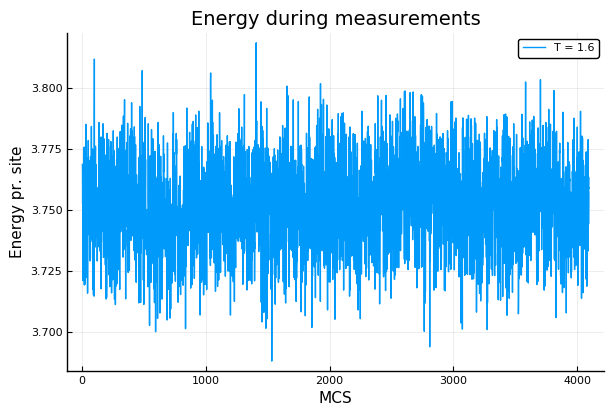

In [7]:
ens_di = JLD.load("energies.jld")
Es = ens_di["Es"]
length(Es)

plt = plot(Es./N; label="T = $(round(T, digits=2))",
        xaxis="MCS", yaxis="Energy pr. site", title="Energy during measurements")
savefig(plt, "measure_energies.pdf")

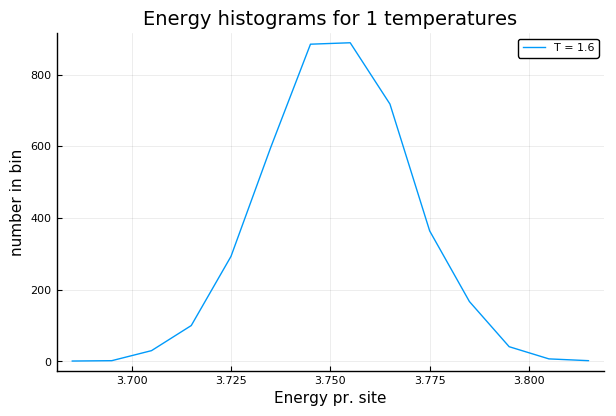

In [8]:
# Plot energy histograms
plotEnergyHistograms([Es./N], [T]);

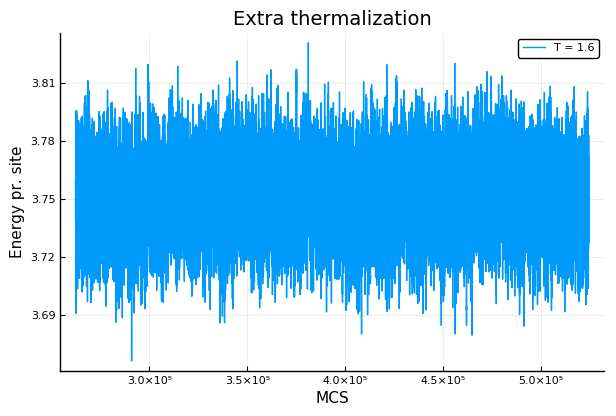

In [9]:
therm_di = JLD.load("thermalization.jld")
M_th = therm_di["M_th"]
M_est = therm_di["M_est"]
M_col = therm_di["M_col"]
E_therm = therm_di["e_thm"];

int = 1:size(E_therm, 1)#floor(Int64, M_th/2)
therm_plt = plot(collect(int).+M_est.+M_col, [E_therm[int, i] for i = 1:N_g]; 
                 label=reshape(["T = $(round(T; digits=2))" for i = 1:N_g], (1, N_g)),
                 xaxis="MCS", yaxis="Energy pr. site", title="Extra thermalization")
savefig(therm_plt, "thermalization energies.pdf")

#### Specific heat

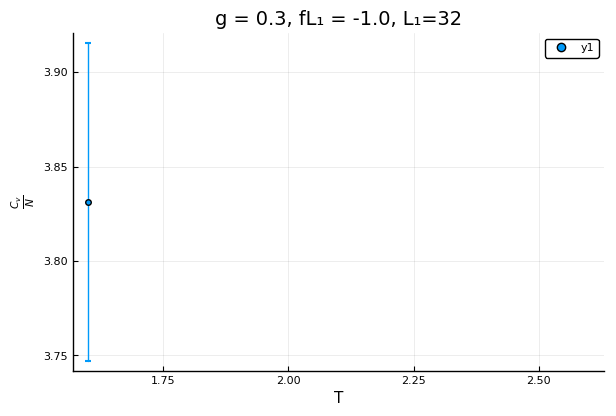

In [10]:
singleSeriesVariancePlot(Es, num_blocks; title="Variance of blocked energy given block size Nb")

jv = jackVars(energies -> specificHeat(energies, 1/T), Es, num_blocks; skip_check=true)
Cv_avg, Cv_var = jackEstimate(jv)
Cv_err = √(Cv_var)

plt = scatter([T], [Cv_avg./N], yerror=[Cv_err./N]; ylabel=L"\frac{C_v}{N}", xlabel="T",
title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "specific_heat.pdf")

#### Structure factor

In [11]:
vo_di = JLD.load("vorticity.jld")
S⁺s = vo_di["sp"];
println("S⁺ measurements")
println("Measures $(length(S⁺s))")
println("Maximum: $(maximum(S⁺s[rand(1:M)])/(L₁*L₂*f*two_pi)^2)")
# Measured k-vector components3
kx = [two_pi/L₁*(x-1-L₁/2) for x = 1:L₁]
ky = [two_pi/L₂*(y-1-L₂/2) for y = 1:L₂];
# Normalizing structure function
normalization = (L₁*L₂*f*two_pi)^2#(L^2*f*two_pi)^2
S⁺s /= normalization;

# Finding if there is correct normalization
S⁺_avg = mean(S⁺s);
println("Maximum in average S⁺: $(maximum(S⁺_avg))")

S⁺ measurements
Measures 4096
Maximum: 1.0000000000000004
Maximum in average S⁺: 1.0000000000000002


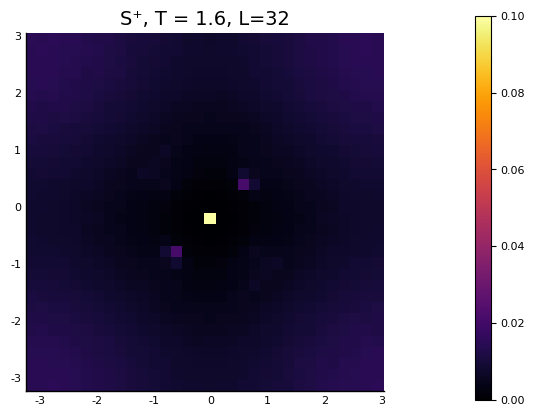

In [12]:
mkcd("S+")
T_round = round(T; digits=2)
plt = heatmap(kx, ky, S⁺_avg; aspect_ratio=1.0, title="S⁺, T = $(T_round), L=$(L₁)", clims=(0, clim_max_meas))
savefig(plt, "S+_avg_T=$(T_round)")
cd("../")

Negative component

In [13]:
S⁻s = vo_di["sm"];
println("S⁻ measurements")
println("Measures $(length(S⁻s))")
println("Maximum: $(maximum(S⁻s[rand(1:M)])/(L₁*L₂*f*two_pi)^2)")
# Normalizing structure function
normalization = (L₁*L₂*f*two_pi)^2
S⁻s /= normalization

S⁻_avg = mean(S⁻s)
println("Maximum in average S⁻: $(maximum(S⁻_avg))")
#heatmap(kx, ky, removeMiddle(S⁻_avg); aspect_ratio=1.0)

S⁻ measurements
Measures 4096
Maximum: 1.0
Maximum in average S⁻: 1.0


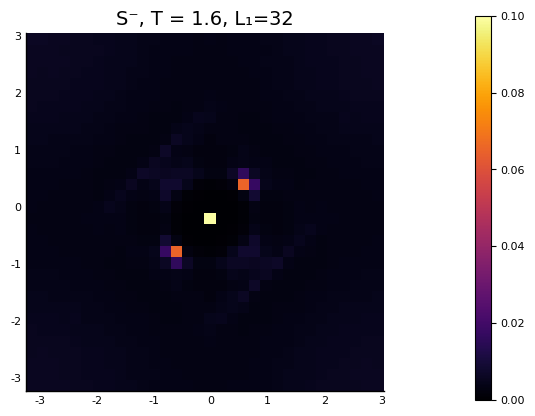

In [14]:
mkcd("S-")
plt = heatmap(kx, ky, S⁻_avg; aspect_ratio=1.0, title="S⁻, T = $(T_round), L₁=$(L₁)", clims=(0, clim_max_meas))
savefig(plt, "S-_avg_T=$(T_round)")
cd("../")

#### Vorticity

In [15]:
vortices = vo_di["vortexes"];

V⁺_snap = vortices[1]
V⁻_snap = vortices[2]
mkcd("V+")
cd("../")
mkcd("V-")
cd("../")
#heatmap(V⁺_snap[:,:,rand(1:L₃)]./two_pi; aspect_ratio=1.0)

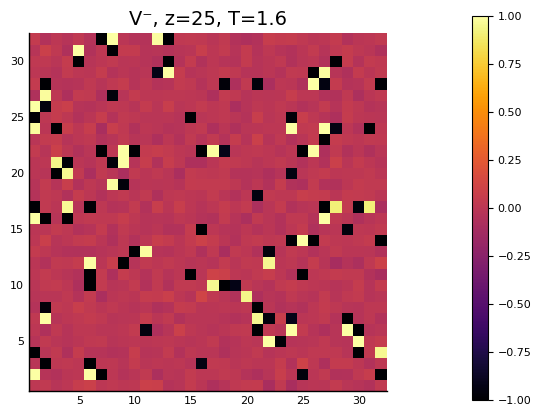

In [16]:
# Plotting vorticity of a single layer
layer = rand(1:L₃)
V⁺ = V⁺_snap[:,:,layer]./two_pi
V⁻ = V⁻_snap[:,:,layer]./two_pi
S⁺, S⁻ = structureFunction(V⁺, V⁻)
normalization = (L₁*L₂*f)^2
S⁺ /= normalization; S⁻ /= normalization
plt⁺ = heatmap(V⁺; aspect_ratio=1.0, clims=(-1, 1), title="V⁺, z=$(layer), T=$(T_round)")
plt⁻ = heatmap(V⁻; aspect_ratio=1.0, clims=(-1, 1), title="V⁻, z=$(layer), T=$(T_round)")
savefig(plt⁺, "V+/V+_snap_T=$(T_round).png")
savefig(plt⁻, "V-/V-_snap_T=$(T_round).png")

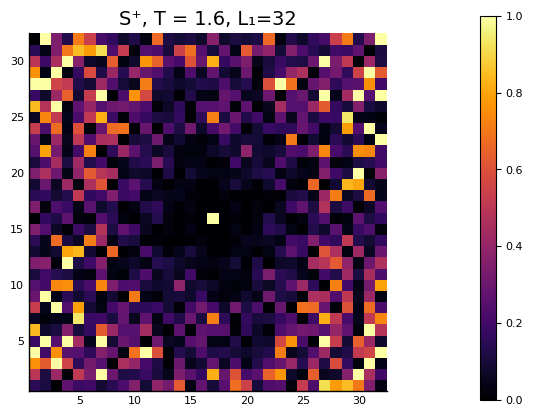

In [17]:

# Saving corresponding fourier transforms
plt_S⁻ = heatmap(S⁻; aspect_ratio=1.0, title="S⁻, T = $(T_round), L₁=$(L₁)", clims=(0, 1.0))
savefig(plt_S⁻, "V-/S-_snap_T=$(T_round)")
plt_S⁺ = heatmap(S⁺; aspect_ratio=1.0, title="S⁺, T = $(T_round), L₁=$(L₁)", clims=(0, 1.0))
savefig(plt_S⁺, "V+/S+_snap_T=$(T_round)")

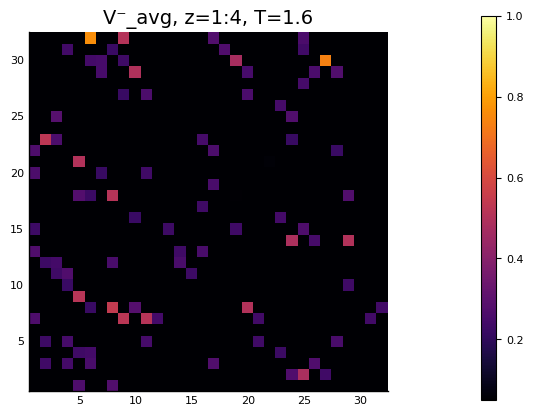

In [18]:
# Plotting vorticity average over n_layers z-layers.
n_layers = 4
V⁺_avg = avgZ(V⁺_snap[:,:,1:n_layers]./two_pi)
V⁻_avg = avgZ(V⁻_snap[:,:,1:n_layers]./two_pi)

plt⁺ = heatmap(V⁺_avg; aspect_ratio=1.0, clims=(0.05, 1), title="V⁺_avg, z=1:$(n_layers), T=$(T_round)")
plt⁻ = heatmap(V⁻_avg; aspect_ratio=1.0, clims=(0.05, 1), title="V⁻_avg, z=1:$(n_layers), T=$(T_round)")
savefig(plt⁺, "V+/V+_avg_T=$(T_round)_layers=$(n_layers).png")
savefig(plt⁻, "V-/V-_avg_T=$(T_round)_layers=$(n_layers).png")

### Long average vorticity

In [19]:
real_vo_di = JLD.load("real_vorticity.jld")
V⁺_avg  = real_vo_di["vp_avg"]; V⁻_avg = real_vo_di["vm_avg"];

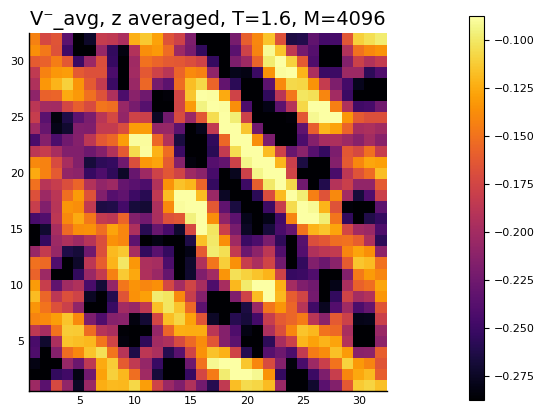

In [20]:
clims_v_max = maximum(V⁺_avg)
clims_v_min = minimum(V⁺_avg)
plt⁺ = heatmap(V⁺_avg; aspect_ratio=1.0, clims=(clims_v_min, clims_v_max), title="V⁺_avg, z averaged, T=$(T_round), M=$(M)")
plt⁻ = heatmap(V⁻_avg; aspect_ratio=1.0, clims=(clims_v_min, clims_v_max), title="V⁻_avg, z averaged, T=$(T_round), M=$(M)")
savefig(plt⁺, "V+/V+_long_avg_T=$(T_round).png")
savefig(plt⁻, "V-/V-_long_avg_T=$(T_round).png")

### XY Vorticity

In [21]:
xy_vortex_path = "XY_Vorticity"
mkcd(xy_vortex_path)
cd("../")

In [22]:
xy_vo_di = JLD.load("XY_vorticity.jld")
Vx_avg  = xy_vo_di["vx_avg"]; Vy_avg = xy_vo_di["vy_avg"];
Sx_avg  = xy_vo_di["sx_avg"]; Sy_avg = xy_vo_di["sy_avg"];
normalization = (L₁*L₂*f*two_pi)^2
Sx_avg /= normalization; Sy_avg /= normalization;
println("Normalization of XY structure functions: ($(round(maximum(Sx_avg)-1; sigdigits=4)), $(round(maximum(Sy_avg)-1; sigdigits=4)))")

Normalization of XY structure functions: (-2.776e-14, -2.776e-14)


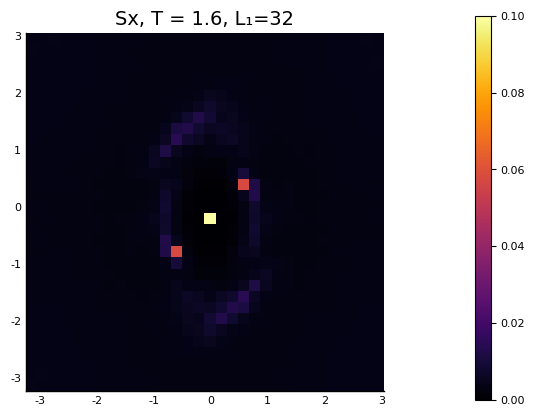

In [23]:
# Plotting structure function
plt_Sx = heatmap(kx, ky, Sx_avg; aspect_ratio=1.0, title="Sx, T = $(T_round), L₁=$(L₁)", clims=(0, clim_max_meas))
plt_Sy = heatmap(kx, ky, Sy_avg; aspect_ratio=1.0, title="Sx, T = $(T_round), L₁=$(L₁)", clims=(0, clim_max_meas))
savefig(plt_Sx, xy_vortex_path*"/Sx_avg_T=$(T_round)")
savefig(plt_Sy, xy_vortex_path*"/Sy_avg_T=$(T_round)")

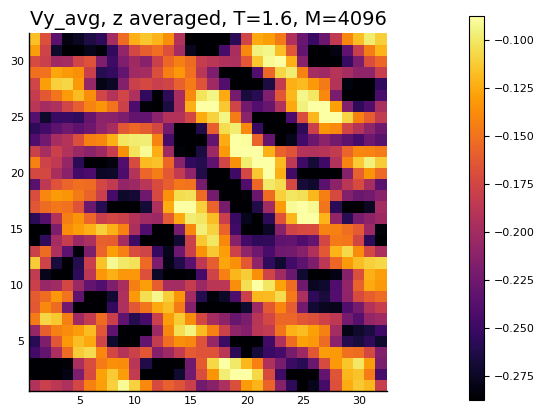

In [24]:
# Plotting average vorticity
plt_Vx = heatmap(Vx_avg; aspect_ratio=1.0, clims=(clims_v_min, clims_v_max), title="Vx_avg, z averaged, T=$(T_round), M=$(M)")
plt_Vy = heatmap(Vy_avg; aspect_ratio=1.0, clims=(clims_v_min, clims_v_max), title="Vy_avg, z averaged, T=$(T_round), M=$(M)")
savefig(plt_Vx, xy_vortex_path*"/Vx_avg_T=$(T_round).png")
savefig(plt_Vy, xy_vortex_path*"/Vy_avg_T=$(T_round).png")

# Amplitudes

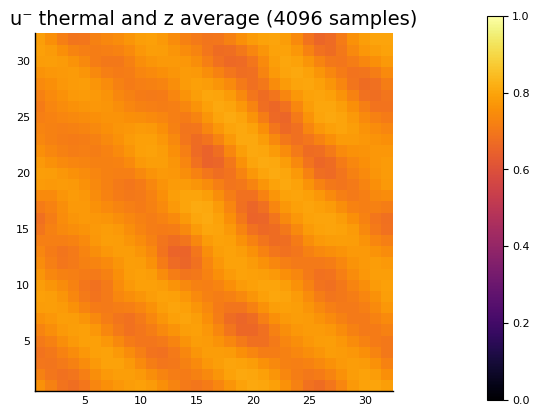

In [25]:
amplitude_di = JLD.load("amplitudes.jld");
u⁻_lattices = amplitude_di["um_lattices"];
u⁺_lattices = amplitude_di["up_lattices"];
u⁻_avg_lattice = amplitude_di["um_xy"];
u⁺_avg_lattice = amplitude_di["up_xy"];
amp_path = "Amplitudes"
mkcd(amp_path);
cd("../")

u⁺_avg = u⁺_avg_lattice./M
u⁻_avg = u⁻_avg_lattice./M
plt = heatmap(u⁺_avg; aspect_ratio=1.0, clims=(0, 1), title="u⁺ thermal and z average ($(M) samples)")
savefig(plt, amp_path*"/u⁺_average.png")
plt = heatmap(u⁻_avg; aspect_ratio=1.0, clims=(0, 1), title="u⁻ thermal and z average ($(M) samples)")
savefig(plt, amp_path*"/u⁻_average.png")

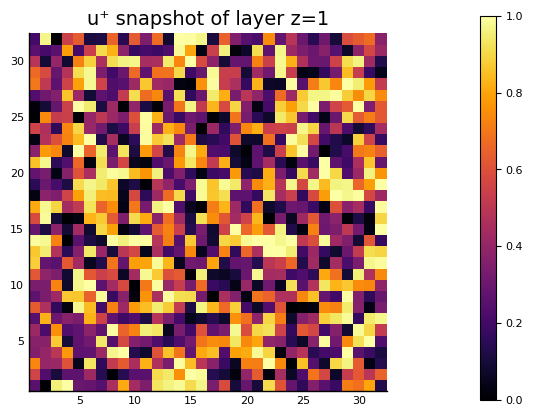

In [26]:

# Plotting amplitude snapshot for layer z = 1
u⁻_xy_snapshot = u⁻_lattices[end][:,:,1]
u⁺_xy_snapshot = u⁺_lattices[end][:,:,1]
plt = heatmap(u⁻_xy_snapshot; aspect_ratio=1.0, clims=(0, 1), title="u⁻ snapshot of layer z=1")
savefig(plt, amp_path*"/u⁻_snapshot.png")
plt = heatmap(u⁺_xy_snapshot; aspect_ratio=1.0, clims=(0, 1), title="u⁺ snapshot of layer z=1")
savefig(plt, amp_path*"/u⁺_snapshot.png")


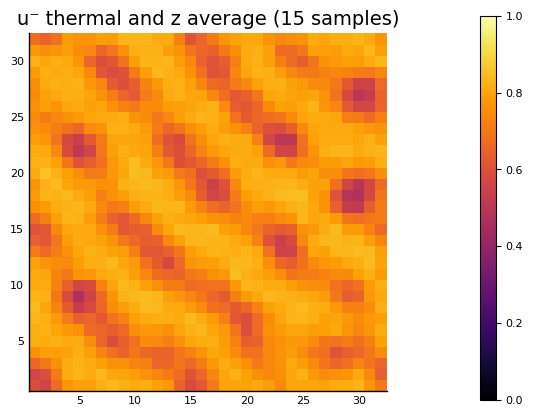

In [27]:

u⁺_layer_avg = u⁺_lattices[1][:,:,1]
u⁻_layer_avg = u⁻_lattices[1][:,:,1]
u⁺_small_avg = avgZ(u⁺_lattices[1])
u⁻_small_avg = avgZ(u⁻_lattices[1]);

for m = 2:M_amp
    u⁺_layer_avg .+= u⁺_lattices[m][:,:,1]
    u⁻_layer_avg .+= u⁻_lattices[m][:,:,1]
    u⁺_small_avg .+= avgZ(u⁺_lattices[m])
    #mean([u⁺_lattice_meas[m][:,:,l] for l = 1:size(u⁺_lattice_meas[1],3)])
    u⁻_small_avg .+= avgZ(u⁻_lattices[m])
    #mean([u⁻_lattice_meas[m][:,:,l] for l = 1:size(u⁻_lattice_meas[1],3)])
end
u⁺_layer_avg ./= M_amp; u⁻_layer_avg ./= M_amp
u⁺_small_avg ./= M_amp; u⁻_small_avg ./= M_amp
plt = heatmap(u⁺_layer_avg; aspect_ratio=1.0, clims=(0,1), title="Layer z = 1 avg of u⁺")
savefig(plt, amp_path*"/u⁺_avg_layer_z=1.png")
plt = heatmap(u⁻_layer_avg; aspect_ratio=1.0, clims=(0,1), title="Layer z = 1 avg of u⁻")
savefig(plt, amp_path*"/u⁻_avg_layer_z=1.png")
plt = heatmap(u⁺_small_avg; aspect_ratio=1.0, clims=(0,1), title="u⁺ thermal and z average ($(M_amp) samples)")
savefig(plt, amp_path*"/u⁺_small_avg.png")
plt = heatmap(u⁻_small_avg; aspect_ratio=1.0, clims=(0,1), title="u⁻ thermal and z average ($(M_amp) samples)")
savefig(plt, amp_path*"/u⁻_small_avg.png")

# Cooldown

In [28]:
cooldown_di = JLD.load("cooldown.jld");
M_pr_step = cooldown_di["M_pr_step"]
N_steps = cooldown_di["N_steps"]
M_col = M_pr_step*N_steps
M_est = cooldown_di["M_est"]
S⁺_col = cooldown_di["sp"];
E_col = cooldown_di["E_list"]
accepts_col = cooldown_di["accepts_list"]
temp_col = cooldown_di["temp_list"];

println("Cooldown:")
println("Steps pr. temp.: $(steps = length(S⁺_col))")
normalization = (L₁*L₂*f*two_pi)^2
S⁺_col = S⁺_col ./ normalization
#S⁺_col_by_T = [S⁺_steps./normalization for S⁺_steps in S⁺_col_by_T];
kx = [two_pi/L₁*(x-1-L₁/2) for x = 1:L₁]
ky = [two_pi/L₂*(y-1-L₂/2) for y = 1:L₂];
mkcd("Cooldown")
cd("../")

Cooldown:
Steps pr. temp.: 1024


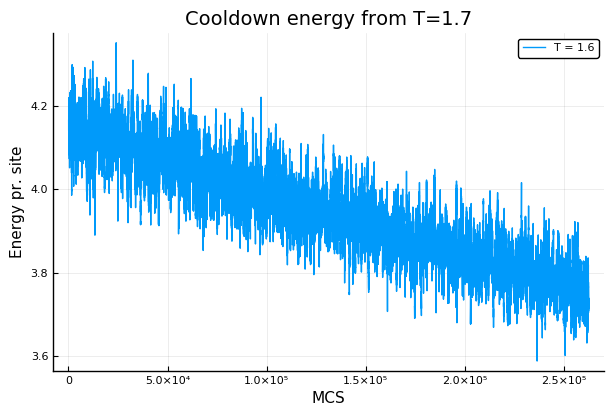

In [29]:
int = 1:M_col+1#floor(Int64, M_th/2)
therm_plt = plot(collect(int).+M_est, E_col[int]; 
                 label="T = $(T_round)",
                 xaxis="MCS", yaxis="Energy pr. site", title="Cooldown energy from T=$(temp_col[1])")
savefig(therm_plt, "Cooldown/cooldown energies.pdf")

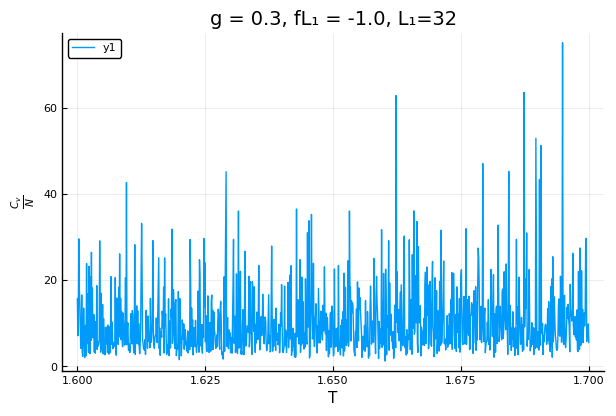

In [30]:
# Estimating specific heat based on cooldown energy
Cv_col = Array{Float64, 1}(undef, N_steps)

Cv_col = [specificHeat(E_col[(step-1)*M_pr_step+1:step*M_pr_step+1].*N, 1/temp_col[step])
        for step = 1:N_steps]

cv_col_plt = plot(temp_col, Cv_col./N;
    ylabel=L"\frac{C_v}{N}", xlabel="T", title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(cv_col_plt, "Cooldown/cooldown_cv.pdf")

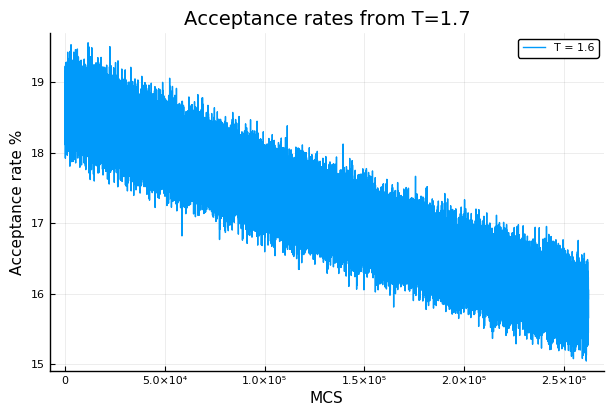

In [31]:
int = 1:M_col#floor(Int64, M_th/2)
ar_plt = plot(collect(int).+M_est, accepts_col[int]./N.*100; 
                 label="T = $(T_round)",
                 xaxis="MCS", yaxis="Acceptance rate %", title="Acceptance rates from T=$(temp_col[1])")
savefig(ar_plt, "Cooldown/cooldown AR.pdf")

### The infamous S+ cooldown

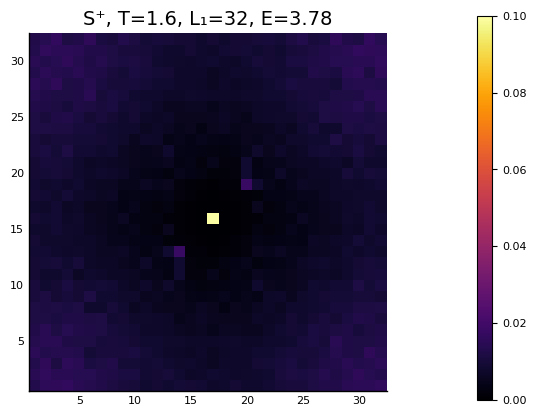

In [32]:

sp_path = "S+_progress"
mkcd(sp_path)
cd("../")

steps = length(S⁺_col)
for s = 1:steps
    S⁺_step = S⁺_col[s]
    plt = heatmap(S⁺_step; aspect_ratio=1.0, clims=(0, clim_max_col), 
        title="S⁺, T=$(round(temp_col[s]; digits=2)), L₁=$(L₁), E=$(round(E_col[(s-1)*M_pr_step+1]; digits=2))")
    savefig(plt, sp_path*"/step=$(lpad(s,4,'0')).png")
end